# How to Explore and Clean Sensitive Data You Can't Even See With Antigranular

## Motivation

Differential privacy is a robust framework to work with highly sensitive data such as PII (personally identification information), financial data, health information, biometric data and so on. When data science and machine learning methods are used on these datasets under differential privacy, there is virtually no chance of extracting individual details from any row. 

But the security provided by the framework comes at a cost - you can only use functions and algorithms that are differentially private. Unfortunately, the vast majority of Python libraries do not meet this requirement, making them useless. 

For this reason, the open-source community offers alternatives to popular libraries for data manipulation and machine learning. In this tutorial, we will learn how to perform Exploratory Data Analysis (EDA) and data cleaning on a sample differentially private dataset using a platform called Antigranular. 

## What is Antigranular?

I've discussed the Antigranular platform in-depth in a [previous article](https://medium.com/towards-artificial-intelligence/antigranular-how-to-access-sensitive-datasets-without-looking-at-them-44090cb22d8a). So, we will only summarize the main points here as understanding them is a requirement for this article. 

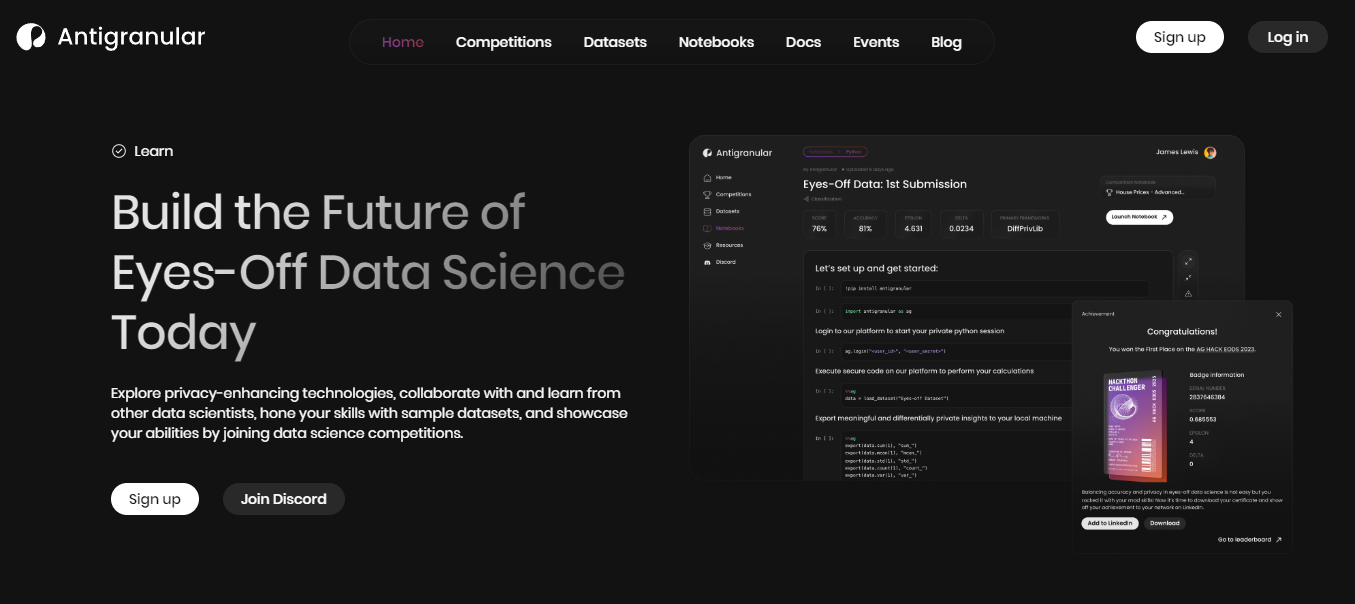

Antigranular is a secure platform for any company to host their sensitive datasets under differential privacy. The platform stores datasets using [AWS Nitro Enclaves](https://aws.amazon.com/ec2/nitro/nitro-enclaves/) that leverage cryptographic attestation for security. Then, the data is exposed to the public through authentication. 

Anyone will be able to use the data but won't be able to actually look at individual rows. This raises the question - why share data that people can't see?

Well, Antigranular isn't just a secure storage - it is a Kaggle-like competition platform where users compete to solve machine learning tasks using DP datasets and methods. It also allows users to share their solutions publicly in notebooks just like in Kaggle. 

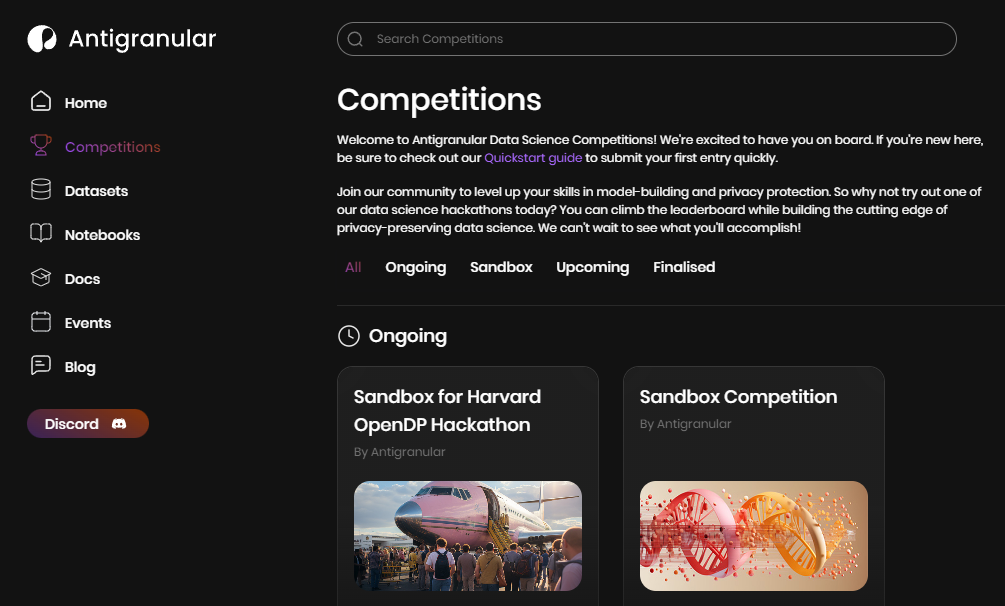

To use the differentially private libraries and datasets locally, Antigranular comes with a Python library in the same name. Today, we will use all of these to perform a typical EDA on the differentially private version of the open-source [Diamonds dataset](https://www.kaggle.com/datasets/shivam2503/diamonds). 

To learn more about Antigranular, please read my [last post](https://medium.com/towards-artificial-intelligence/antigranular-how-to-access-sensitive-datasets-without-looking-at-them-44090cb22d8a). 

## Setup

We start the EDA by connecting to the differentially private Diamonds dataset available on [this page of Antigranular (AG)](https://www.antigranular.com/datasets/65cb18fe5f09c08e900036c2). If you already signed up for the platform, each dataset page will display a snippet that shows how to connect to the Nitro Enclave containing the dataset. Copy it:

![](images/login.gif)

Then, snip up a local Jupyter session and run the snippet you just copied:

```python
import antigranular as ag  # pip install antigranular

session = ag.login(
    "*****************",
    "******************************",
    dataset="Diamonds Dataset",
)
```

```
[OUT]:

....
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!
```

If the login is successful, you will get a message that says the dataset has been loaded as `diamonds_dataset` and that the `%%ag` cell magic has been registered into your environment. 

From this point on, your Jupyter session is connected to two machines (servers): your own local machine and the Nitro enclave of Antigranular.

If your cell starts with the `%%ag` cell magic, the next lines of code will be run on the enclave. It comes with a DP version of Python and a few differentially private and other regular open-source libraries of the data stack already installed. 

This means that if you want to perform any operation on `diamonds_dataset`, it must be inside a cell with `%%ag` magic:

In [137]:
import antigranular as ag

session = ag.login(
    "fmcpKlIoyH2MZIojkMUY8TeqI/QRY1A6",
    "G4R6B9uXc5XjKenVP0BSvIHcoxSlK+NqtNraAjiwOcfoOLrbz2Tg7rT/04ruIMpZ",
    dataset="Diamonds Dataset",
)

local_host_port: ecb96ed7-2d57-477a-91e1-8efa084ebb7c
server_hostname: ip-100-100-18-55.eu-west-1.compute.internal
cert_thumbprint: c6a041c41fca78dd32dfe884a8879faa1d547777355cf3efa55382d21ec97d7589396c46ffb35042e7d21616a2e6c1a3bc2d429a5669c38797fa1143bbcfbff8
tls_cert_name: ip-100-100-18-55.eu-west-1.compute.internal_ecb96ed7-2d57-477a-91e1-8efa084ebb7c
Dataset "Diamonds Dataset" loaded to the kernel as diamonds_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: c8544b03-c818-453e-97b6-04eea05f9415, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


In [139]:
%%ag

train_X = diamonds_dataset["train_x"]
train_y = diamonds_dataset["train_y"]

The above snippet extracts the feature and target arrays from the `diamonds_dataset` variable inside the enclave. If you it without the magic, you will get a name error:

In [136]:
train_X = diamonds_dataset["train_x"]
train_y = diamonds_dataset["train_y"]

NameError: name 'diamonds_dataset' is not defined

`train_X` and `train_y` are instances of `PrivateDataFrame` class included in the `op_pandas` library:

In [115]:
%%ag

from op_pandas import PrivateDataFrame, PrivateSeries

`op_pandas` is a smaller version of Pandas that contains differentially private functions and methods. Columns in private dataframes are represented by `PrivateSeries`.

## 1. Looking at the data

We can't look at the actual rows because of DP but we have other methods to get a feel for the dataset, starting with column names:

In [35]:
%%ag

# Print the columns of the dataset
ag_print("Columns: \n", train_X.columns)

Columns: 
 ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']



Then, we can print the data type of each column above:

In [36]:
%%ag

ag_print("Dtypes: \n", train_X.dtypes)

Dtypes: 
 carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
dtype: object



The data types are mostly correctly assigned (the object data type is not ideal for string columns). 

Now, let's look at the 5-number summary of the dataset, which will tell us the standard deviation, mean, median and percentiles of each numeric column:

In [37]:
%%ag

results = train_X.describe(eps=1)

ag_print(results)

              carat         depth  ...             y             z
count  37717.000000  37728.000000  ...  37731.000000  37746.000000
mean       0.804813     61.806690  ...      5.616625      3.562508
std        0.443778      1.825406  ...      1.874300      2.116515
min        0.200000     43.000000  ...      0.000000      0.000000
25%        0.439432     60.489722  ...      4.964873      2.804861
50%        0.709064     61.770117  ...      5.688359      3.618784
75%        0.983109     63.112093  ...      6.425548      3.778991
max        4.802821     68.814405  ...     41.519457     30.588921

[8 rows x 6 columns]



The 5-number summary is calculated using `describe` but as you must have noticed, this version of `describe` has a parameter called `eps`. The new parameter stands for _epsilon_, which controls the level of deliberate noise injected into each calculation. It ranges from 0 to infinity but typically stays in the 1-5 range depending on the function used. 

As you might guess, epsilon is an important parameter of differential privacy. At the start of each session, you start with a large epsilon budget. The more you use it, the less private and secure your code becomes. So, you have to strike the balance between epsilon and usability. If you use too much epsilon, your code becomes less differentially private whereas, being too strict with epsilon may introduce way too much noise in your calculation and make it useless. 

To see how close `describe` with one epsilon is to the actual 5-number summary of Diamonds dataset, we will compare it to the open-source version. But that comparison can only be made locally, outside the Nitro enclave. So, what can we do?

When you need the results of computations locally, AG allows you to export them from the enclave:

In [38]:
%%ag

export(results, name="results")

Setting up exported variable in local environment: results


The syntax is very simply. The above code loads the results of the 5-number summary into our local Jupyter session:

In [39]:
print(results)

              carat         depth         table             x             y  \
count  37717.000000  37728.000000  37773.000000  37776.000000  37731.000000   
mean       0.804813     61.806690     57.529598      5.707087      5.616625   
std        0.443778      1.825406      3.693945      0.943331      1.874300   
min        0.200000     43.000000     43.000000      0.000000      0.000000   
25%        0.439432     60.489722     55.876997      4.616063      4.964873   
50%        0.709064     61.770117     56.564244      5.604013      5.688359   
75%        0.983109     63.112093     57.936230      6.825518      6.425548   
max        4.802821     68.814405     79.931229     10.119966     41.519457   

                  z  
count  37746.000000  
mean       3.562508  
std        2.116515  
min        0.000000  
25%        2.804861  
50%        3.618784  
75%        3.778991  
max       30.588921  


Now, to compare `results` with the actual 5-number summary, we will load the Diamonds dataset through Seaborn and call `describe`:

In [40]:
import seaborn as sns

diamonds = sns.load_dataset("diamonds")
results_local = diamonds.describe()

To find the differences, we just subtract `results_local` from `results`:

In [41]:
results - results_local

,carat,depth,price,table,x,y,z
count,-16223.000000,-16212.000000,NaN,-16167.000000,-16164.000000,-16209.000000,-16194.000000
mean,0.006873,0.057285,NaN,0.072414,-0.024070,-0.117901,0.023774
std,-0.030233,0.392784,NaN,1.459454,-0.178430,0.732166,1.410817
min,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,0.039432,-0.510278,NaN,-0.123003,-0.093937,0.244873,-0.105139
50%,0.009064,-0.029883,NaN,-0.435756,-0.095987,-0.021641,0.088784
75%,-0.056891,0.612093,NaN,-1.063770,0.285518,-0.114452,-0.261009
max,-0.207179,-10.185595,NaN,-15.068771,-0.620034,-17.380543,-1.211079


As you can see, for almost all columns, the differences are marginal, which means we used the right amount of epsilon.

There are other statistical functions supported in `op_pandas`, like `.percentile`. Let's use it to find the minimum and maximum of the target (diamond prices):

In [42]:
%%ag

price_min = train_y.percentile(eps=0.1, p=0)
price_max = train_y.percentile(eps=0.1, p=100)

ag_print(price_min)
ag_print(price_max)

price    345.430128
dtype: float64
price    18490.061918
dtype: float64



`.percentile` also accepts epsilon and also, the percentile itself with `p`. Let's compare this with the actual minimum and maximum of diamond prices:

In [43]:
diamonds.price.min()

326

In [44]:
diamonds.price.max()

18823

We are close nut close enough. Let's increase epsilon and see what happens:

In [45]:
%%ag

price_min = train_y.percentile(eps=0.2, p=0)
price_max = train_y.percentile(eps=0.2, p=100)

ag_print(price_min)
ag_print(price_max)

price    333.53453
dtype: float64
price    18815.210025
dtype: float64



We got even closer! But keep in mind that when you are working with real-world DP datasets, you won't have any means of checking whether you set the right amount of epsilon. This will come through practice and experience.

## 2. Cleaning data

This is a secttion on cleaning data
but dimonds is pretty  clean 
so, htere isn't much to do here

But in any scenario, you start by copying the original datasetes and start clean them

Diamonds dataset is relatively clean, so there isn't much to do in this section. But in any case, data cleaning starts with copying the data so that you won't mess it up accidentally. Like in `pandas`, `op_pandas` has `.copy` function:

In [46]:
%%ag

train_X_copy = train_X.copy()
train_y_copy = train_y.copy()

One of the most common operations in cleaning is dropping unnecessary columns. For example, when loading CSVs, you might have come across to the `Column: 0` column, which is for index:

```python
%%ag

# Hypothetical
train_X.drop(columns="Column: 0", inplace=True)  # Default
```

Dropping columns is the same in Pandas and there is no need to spend epsilon. You can also drop missing values without epsilon:

```python
%%ag

train_X.dropna(axis=0)  # Across the rows
```

Another common operation is renaming columns. Here is how to rename "price" to "target":

In [47]:
%%ag

ag_print(train_y.columns)

['price']



In [48]:
%%ag

renamed_target = train_y_copy.rename({"price": "target"})

ag_print(renamed_target.columns)

['target']



This doesn't use epsilon either. 

## 3. Selecting data

selecting a column and printing won't do anything since we can't look at the actual calues
So, we can chain it with count to know the number of samples in the colujmn

Retrieving and subsetting necessary parts of datasets is pretty common. For example, you can use the familiar brackets notation to select columns:

In [49]:
%%ag

ag_print(train_X["cut"].count(eps=0.1))

37720



Above, we are printing the number of rows of the `cut` column using `count`, which accepts epsilon. It is also possible to select multiple columns:

In [50]:
%%ag

selected_cols = train_X[["cut", "color"]]

ag_print("Selected columns:\n", selected_cols.columns)

Selected columns:
 ['cut', 'color']



It is also possible to filter (select) the data based on a condition. For example, we are filter the dataset for diamonds with half a carat or less:

In [51]:
%%ag

# Filter for diamonds below half a carat
low_carat = train_X.where(train_X["carat"] < 0.5)

ag_print(low_carat.count(eps=0.1))

carat      12252
cut        12434
color      12308
clarity    12355
depth      12263
table      12243
x          12371
y          12278
z          12471
dtype: int64



The condition is specified inside the `where` function - no epsilon. You can also chain conditions with `| - or` and `& - and` operators. Below, we will choose diamonds carat below 0.5 and depth over 65: 

In [142]:
%%ag

temp = train_X.where((train_X["carat"] < 0.5) & (train_X["depth"] > 65))
ag_print(temp.count(eps=0.1))

carat      154
cut          0
color      164
clarity     95
depth        0
table        3
x           61
y           36
z            0
dtype: int64



Some of the columns have a count of 0, which suggest that there might be no diamonds matching our condition.

Let's do a final filter for diamonds with carat over three:

In [52]:
%%ag

# Filter for diamonds above three carats
high_carat = train_X.where(train_X["carat"] > 3)

ag_print(high_carat.count(eps=0.1))

carat        0
cut        105
color      347
clarity    229
depth        0
table       52
x            0
y            0
z            0
dtype: int64



## 4. Joining data in Antigranular

Joining data is a common operation in cealning data

The most basic oin is concatenation along an axis. For example, to do a vertical concat, so that two datasets with the same number of cols and col names collectivly form a dataset with more rows

In [53]:
%%ag
import op_pandas as opd

# Doesn't require epsilon
concatenated_diamonds = opd.concat([low_carat, high_carat])

ag_print(concatenated_diamonds.columns)
ag_print(concatenated_diamonds.count(eps=0.1))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']

carat      12464
cut        12383
color      12315
clarity    12377
depth      12386
table      12341
x          12461
y          12507
z          12325
dtype: int64



Confirmed!

To concatenate horizontally, so that a dataset ends up with more cols, you can use `join` with how to outer

There is also the `join` function that performs the same

## 5. Looping functions

You can't loop over values of dp datasets. Insetead, you can use built-in funcs of private dfs:

- map
- applymap

Here is show to use applymap

In [54]:
%%ag


def absolute(x: int | float) -> float:
    return abs(x)


num_cols = train_X[["carat", "x", "y", "z", "depth"]]
num_cols_abs = num_cols.applymap(absolute, eps=1)

ag_print(num_cols_abs.count(eps=0.1))

carat    37751
x        37677
y        37726
z        37709
depth    37897
dtype: int64



Above, we are taking the absolute value of each cell in a private df to make sure there aren't negative vals.

To apply a function to a single clum, you can use map function

In [55]:
%%ag


def lower(x: np.object) -> str:
    return str(x)


train_X_copy["cut"] = train_X_copy["cut"].map(lower, eps=0.3)

ag_print(train_X_copy.dtypes)

RuntimeError: Restricted, object is blocked on the applied object


Keep in mind that both applymap and map require functions with detailed function signatures. The function definition must have type annotations for parameter vals and return vals just like above.

## 6. Plotting a histogram in Antigranular

Due to the nature of DP, plotting a bit trickier but we can use some other methods to do so

here is how to plot a histogram

first, we calculate the bin locations and bin heights with .hist function

In [63]:
%%ag

# The default number of bins is 10
hist_data = train_y_copy.hist(column="price", eps=0.1, bins=10)
export(hist_data, "hist_data")

Setting up exported variable in local environment: hist_data


Tjhen, to plot the data in matplotlib, we should explort the data locally

afterwards, we extract the hist components, and pass them to plt.bar, We also specify a width for each bin

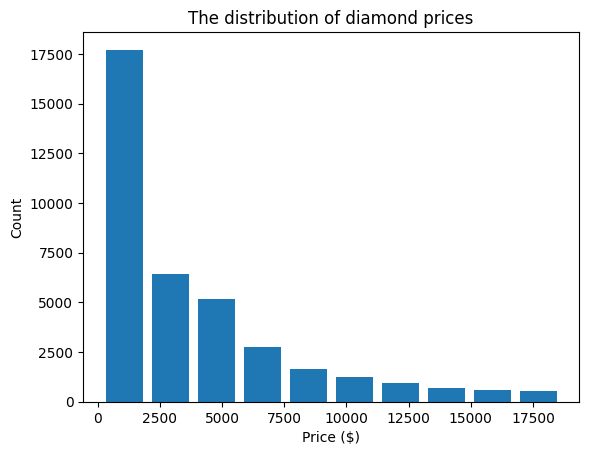

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the bin locations and heights
bin_heights, bin_x = hist_data

# Create a histogram with plt.bar
plt.bar(bin_x[:-1], bin_heights, width=np.diff(bin_x) * 0.8, align="edge")

plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.title("The distribution of diamond prices")

# Display the plot
plt.show()

Now, let' ssee a 2d histogram. It alows us to see rels between two numeric features. so, we will try a 2d hist of carat and price

Since they are in two different objects, trainx and trainy, we concat them using y

In [86]:
%%ag
# Concatenate X and y arrays
diamonds_full = train_X.join(train_y, how="outer")

# Create a 2D histogram
hist2d = diamonds_full.hist2d(x="price", y="carat", eps=0.3, bins=15)
# Export locally
export(hist2d, "hist2d")

Setting up exported variable in local environment: hist2d


After concatting, we use the hist2d function wth 15 bins and export the result

Then, we plot using the matshow function of mpl which allows plotting matrices using a colorbar

Fiurst we extract the histogram components, h xbins ybins

then we pass them t omatshow in the exact order as shown below, we store the result into cax so that we can pass it to colorbar later

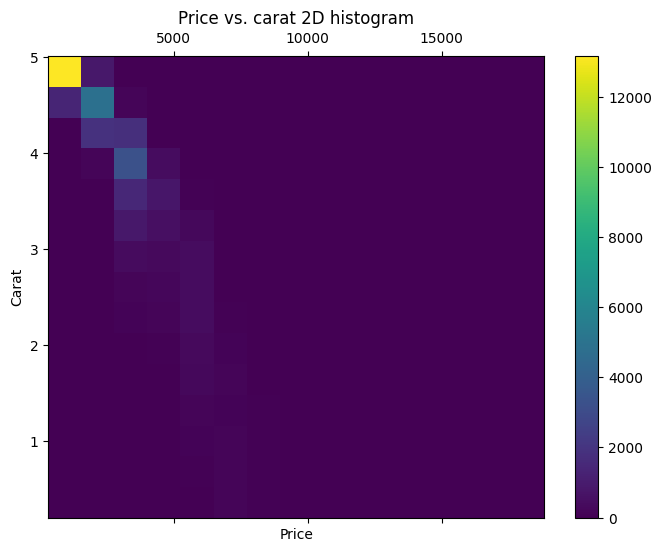

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract the 2D histogram components
h, xbins, ybins = hist2d

# Plot the histogram
cax = ax.matshow(h, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], aspect="auto")
ax.set(title="Price vs. carat 2D histogram", xlabel="Price", ylabel="Carat")
# Add a colorbar
plt.colorbar(cax, ax=ax)

plt.show()

The plot shows an interesting trend in the top left corner - even though the carat is very high the price is very low. This doesn't make sense so, I will leave it to you to explore further, maybe we used too low epsilon

## 7. Plotting a correlation matrix in Antigranular

It is also possible to plot a correlation matrix in ag to see the overall rels between each numeric feature pair.

Hte corr matrix is calculated using .corr function. Then we export the results

In [105]:
%%ag

corr_matrix = diamonds_full.corr(eps=5)
export(corr_matrix, "corr_matrix")

/code/dependencies/op_pandas/op_pandas/utils/stat_utils.py:240: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(



Setting up exported variable in local environment: corr_matrix


After wards, we do some preprocessing such as filling in the miss values and bounding the too large or too low correlations between 0 and 1

then, we pass the matrix to the heatmap function, which results in this beautiful coo matrix

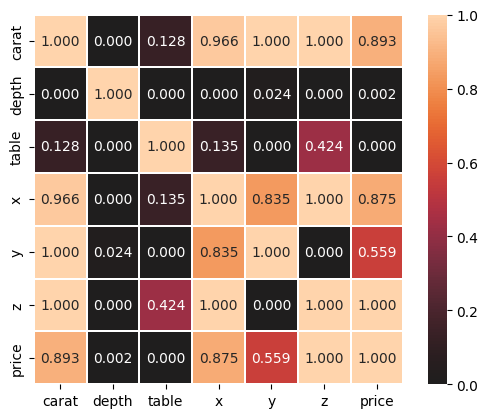

In [106]:
# Pre-process
corr_matrix = corr_matrix.fillna(0)
corr_matrix = corr_matrix.clip(0, 1)

sns.heatmap(corr_matrix, center=0, fmt=".3f", square=True, annot=True, linewidth=0.3);

## 8. Plotting a scatterplot in Antigranular

In [118]:
%%ag

import numpy as np

xs = np.arange(0, 1, 0.01)
percentiles_price = []
percentiles_carat = []

for x in xs:
    carat = train_X["carat"].percentile(x, eps=0.1)
    price = train_y["price"].percentile(x, eps=0.1)

    percentiles_carat.append(carat)
    percentiles_price.append(price)

In [128]:
%%ag

export(percentiles_price, "prices")
export(percentiles_carat, "carats")

Setting up exported variable in local environment: prices
Setting up exported variable in local environment: carats


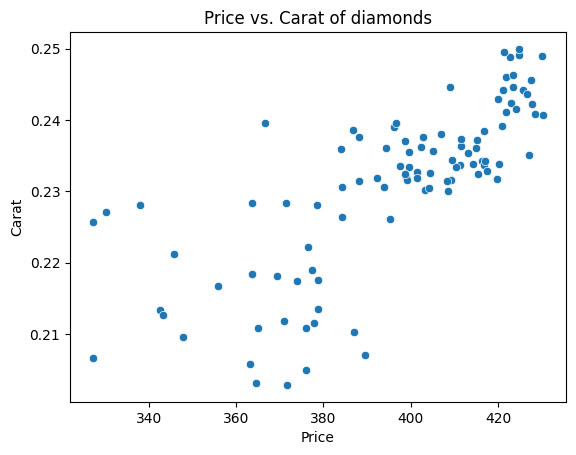

In [129]:
ax = sns.scatterplot(x=prices, y=carats)

ax.set(title="Price vs. Carat of diamonds", xlabel="Price", ylabel="Carat")
plt.show();

In [130]:
import numpy as np

xs = np.arange(0, 1, 0.01)
percentiles_price = []
percentiles_carat = []

for x in xs:
    carat = diamonds["carat"].quantile(x)
    price = diamonds["price"].quantile(x)

    percentiles_carat.append(carat)
    percentiles_price.append(price)

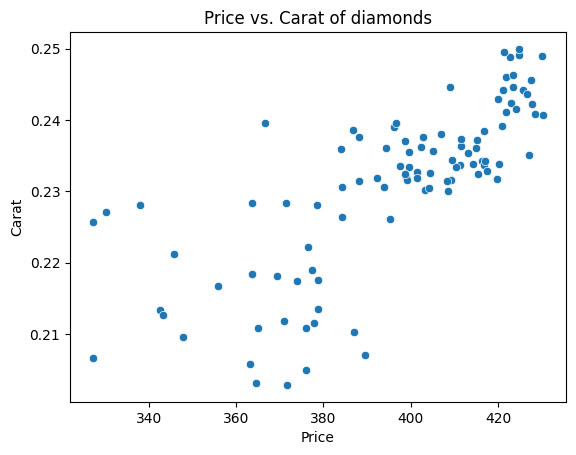

In [131]:
ax = sns.scatterplot(x=prices, y=carats)

ax.set(title="Price vs. Carat of diamonds", xlabel="Price", ylabel="Carat")
plt.show();

## Conclusion